In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from torch import optim
from torch.utils.data import DataLoader
from dataload import lang, localdata
from tagger.bilstm import BiLSTM
from etc.customUtil import showGraph, showParallel

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
tag_PAD = lang.tag_PAD
tag_UNK = lang.tag_UNK

datasets, engdict, posdict = localdata.load_eng_pos(device)
num_words = engdict.n_words
num_chars = engdict.n_chars
num_poss = posdict.n_words
print(num_words)
print(num_chars)
print(num_poss)
# print(MAX_LENGTH)
print(engdict.max_len_char)
print(engdict.max_len_word)
print(posdict.max_len_char)
print(posdict.max_len_word)

print(len(datasets['dev'].y_data))
print(len(datasets['test'].y_data)) 
print(len(datasets['train'].y_data))

21591
82
46
54
78
4
78
936
2012
8000


In [5]:
def iteration(samples, optimizer, criterion):
    x_train, y_train = samples
        
    optimizer.zero_grad()

    o = model(x_train)
    o = o.view(-1,o.size(-1))
    t = y_train.view(-1)

    loss = criterion(o, t)
    loss.backward()
    optimizer.step()

    return loss.item()

In [6]:
def epoch(model, optimizer, criterion, dataloader):
    model.train()
    list_loss = []
    for batch_idx, samples in enumerate(dataloader):
        loss = iteration(samples, optimizer, criterion)
        list_loss.append(loss)
    return list_loss

In [7]:
def evaluate(model, criterion, dataloader):
    model.eval()
    total_loss = 0
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples

        o = model(x_train)
        o = o.view(-1,o.size(-1))
        t = y_train.view(-1)

        total_loss += criterion(o, t).item()

        # if batch_idx % 100 == 0:
            # print(batch_idx, loss.item())
            
    # print(batch_idx, loss.item())
    return total_loss / (batch_idx+1)

In [8]:
def scores(model, dataset, batch_size):
    model.eval()
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    total_samples = len(dataset)
    cnt_corr_samples = 0
    total_words = 0
    cnt_corr_words = 0
    c = posdict.n_words
    table = torch.zeros(c,c)
    
    for batch_idx, samples in enumerate(dataloader):
        x_train, y_train = samples
        
        o = model(x_train)
        t = y_train.view(-1)

        __tagged, tagged = torch.max(o, dim=-1)
        
        for i in range(x_train.size(0)):
            l = y_train[i].tolist()
            if tag_PAD in l:
                seq_len = l.index(tag_PAD)
            else:
                seq_len = len(l)
            
            _y = y_train[i,:seq_len]
            _p = tagged[i,:seq_len]
            d = _p!=_y
            cnt_wrong = _p[d].size()[0]
            
            # score1_acc_sample
            if cnt_wrong == 0:
                cnt_corr_samples +=1
                
            # score2_acc_word
            total_words += seq_len
            cnt_corr_words += seq_len - cnt_wrong
            
            # score3_f1
            for j in range(seq_len):
                table[_y[j],_p[j]] += 1

    tp = torch.tensor([table[i,i] for i in range(c)])[2:]
    d0sum = table[2:,2:].sum(dim=0)
    d1sum = table[2:,2:].sum(dim=1)
    allsum = d1sum.sum()
    
    pr = tp / d0sum
    temp = pr != pr
    pr[temp] = 0
    
    re = tp / d1sum
    temp = re != re
    re[temp] = 0
    
    f1 = 2 * pr * re / (pr + re)
    temp = f1 != f1
    f1[temp] = 0
    
    avg_f1 = (f1 * d1sum).sum() / allsum
  
    return (cnt_corr_samples / total_samples,
            cnt_corr_words / total_words,
            avg_f1.item())

In [9]:
def train_losses_scores(model, optimizer, criterion, datasets, batch_size, num_epoch):

    dict_losses={'train': [],
                 'dev': [],
                 'test': []
                }
    
    dict_scores={'train': [[],[],[]],
                 'dev': [[],[],[]],
                 'test': [[],[],[]]
                }
    best_dev_f1 = 0.0
    for epoch_i in range(1,num_epoch+1):
        dataloader = DataLoader(datasets['train'], batch_size=batch_size, shuffle=True)
        dataloader_dev = DataLoader(datasets['dev'], batch_size=len(datasets['dev']), shuffle=True)
        dataloader_test = DataLoader(datasets['test'], batch_size=len(datasets['test']), shuffle=True)
        print(f'\r{epoch_i}', end='')
        temp = epoch(model, optimizer, criterion, dataloader)
        dict_losses['train'].extend(temp)
        dict_losses['dev'].append(evaluate(model, criterion, dataloader_dev))
        dict_losses['test'].append(evaluate(model, criterion, dataloader_test))

        s_train = scores(model, datasets['train'], 100)
        s_dev = scores(model, datasets['dev'], 100)
        s_test = scores(model, datasets['test'], 100)
        
        dict_scores['train'][0].append(s_train[0])
        dict_scores['train'][1].append(s_train[1])
        dict_scores['train'][2].append(s_train[2])
        dict_scores['dev'][0].append(s_dev[0])
        dict_scores['dev'][1].append(s_dev[1])
        dict_scores['dev'][2].append(s_dev[2])
        dict_scores['test'][0].append(s_test[0])
        dict_scores['test'][1].append(s_test[1])
        dict_scores['test'][2].append(s_test[2])

        if s_dev[2] > best_dev_f1:
            print(f' epoch Dev F1 score: {best_dev_f1:.6} -> {s_dev[2]:.6}')
            best_dev_f1 = s_dev[2]
            torch.save(model, 'best_bilstm_pos.pt')
    print()
    return dict_losses, dict_scores

In [10]:
def pos_tagging(model, input_seq):
    model.eval()
    o = model(input_seq)
    __tagged, tagged = torch.max(o, dim=-1)
    return tagged

In [11]:
def calc(model, input_seq, target_seq=None):
    input_list = engdict.sentenceFromIndexes(input_seq.tolist())
#     print(input_list)
    # print(sentenceFromIndexes(posdict, target_seq.tolist()))
    output_list = posdict.sentenceFromIndexes(pos_tagging(model, input_seq.unsqueeze(0)).view(-1).tolist())
    
    target_list = None
    if target_seq is not None:
        target_list = posdict.sentenceFromIndexes(target_seq.tolist())

#     print(output_list)
    showParallel(input_list, output_list, target_list)

In [12]:
embedding_dim = 100
size_hidden = 50
num_layers = 1
size_out = num_poss
size_batch = 100
# criterion  = nn.CrossEntropyLoss().to(device)
criterion  = nn.CrossEntropyLoss(ignore_index=tag_PAD).to(device)

In [13]:
model = BiLSTM(num_words, embedding_dim, size_hidden, size_out, num_layers, tag_PAD).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epoch = 60
st = time.time()
dict_losses, dict_scores = train_losses_scores(model, optimizer, criterion, datasets, size_batch, num_epoch)
print(f'\t{time.time()-st:5}')

1 epoch Dev F1 score: 0.0 -> 0.884158
2 epoch Dev F1 score: 0.884158 -> 0.933617
3 epoch Dev F1 score: 0.933617 -> 0.945804
4 epoch Dev F1 score: 0.945804 -> 0.950227
5 epoch Dev F1 score: 0.950227 -> 0.950599
6 epoch Dev F1 score: 0.950599 -> 0.951287
7 epoch Dev F1 score: 0.951287 -> 0.95188
8 epoch Dev F1 score: 0.95188 -> 0.952095
9 epoch Dev F1 score: 0.952095 -> 0.953156
13 epoch Dev F1 score: 0.953156 -> 0.953282
16 epoch Dev F1 score: 0.953282 -> 0.953964
37 epoch Dev F1 score: 0.953964 -> 0.954431
60


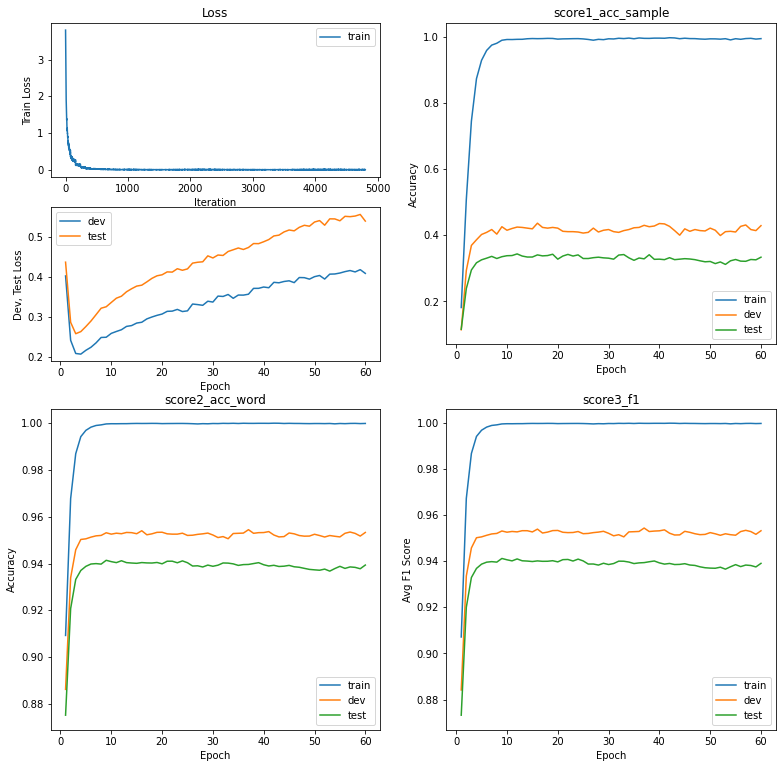

In [14]:
showGraph(dict_losses, dict_scores)

In [15]:
score_type=1
for i in range(len(dict_scores["train"][score_type])):
    print(f'{dict_scores["train"][score_type][i]:<.5}   {dict_scores["dev"][score_type][i]:<05.4}   {dict_scores["test"][score_type][i]:.5}')

0.90929   0.8863   0.87523
0.96774   0.9339   0.92076
0.9869   0.9459   0.93322
0.9942   0.9503   0.93704
0.99688   0.9506   0.93881
0.99825   0.9513   0.9398
0.99896   0.9518   0.93997
0.99922   0.952   0.93976
0.99962   0.9531   0.94139
0.99971   0.9526   0.94082
0.9997   0.953   0.94039
0.99973   0.9527   0.9412
0.99974   0.9533   0.94039
0.9998   0.9532   0.94022
0.99984   0.9527   0.9401
0.99982   0.954   0.94041
0.99983   0.9523   0.94027
0.99986   0.9527   0.94022
0.99984   0.9533   0.94046
0.99976   0.9534   0.93989
0.99979   0.9527   0.94098
0.9998   0.9526   0.94101
0.99982   0.9526   0.94033
0.99983   0.953   0.94113
0.99979   0.952   0.94035
0.99972   0.9521   0.93894
0.99962   0.9525   0.93904
0.99974   0.9527   0.93854
0.99968   0.953   0.93934
0.9998   0.9522   0.93883
0.99977   0.9511   0.9393
0.99987   0.9515   0.94025
0.99983   0.9506   0.94018
0.99989   0.9528   0.93987
0.99981   0.9529   0.93921
0.99991   0.953   0.93955
0.99986   0.9545   0.93961
0.99986   0.9529  

In [21]:
testset = datasets['test']
for ii in range(len(testset)):
    i = 3
    input_seq = testset.x_data[i]
    target_seq = testset.y_data[i]
    calc(model, input_seq, target_seq)
    break
#     print(target_seq)

words               tags    targets
Under               IN      IN
the                 DT      DT
existing            VBG     VBG
contract            NN      NN
,                   ,       ,
Rockwell            NN      NNP
said                VBD     VBD
,                   ,       ,
it                  PRP     PRP
has                 VBZ     VBZ
already             RB      RB
delivered           VBN     VBN
793                 NNS     CD
of                  IN      IN
the                 DT      DT
shipsets            NNS     NNS
to                  TO      TO
Boeing              NNP     NNP
.                   .       .


In [17]:
sen = 'I am your father .'
in_sen = torch.tensor(engdict.indexesFromSentence(sen), device=device)

sen2 = [4609,   25,   35,  116, 4610, 1562,   74,  115, 4611,   49, 4612, 1456,
        4613,  224,  691,    6, 4614,   76,   30, 1742, 4615,  308,  107, 4614,
         116, 4616, 4617,   17]
in_sen2 = torch.tensor(sen2, device=device)

calc(model, in_sen)

words               tags
I                   PRP
am                  VBP
your                PRP$
father              NN
.                   .
